In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from collections import Counter

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

## Data sampling

To make the application more useful, I want the dataset to focus on the most popular boooks. To achieve this, I keep the 3000 books that have the most reviews. After that, I keep maximum 3 reviews per book.

In [2]:
file_path = os.path.join('..', 'data', 'data_origin.csv')

title_counts = Counter()

# Read in chunks of 10,000 rows
for chunk in pd.read_csv(file_path, usecols=['Title'], chunksize=100_000):
    # Drop missing titles
    chunk = chunk.dropna(subset=['Title'])
    title_counts.update(chunk['Title'])

# Convert to df
title_df = pd.DataFrame(title_counts.items(), columns=['Title', 'count'])

# Keep top 3000 popular titles
top_titles = title_df.nlargest(3000, 'count')['Title'].tolist()

print(f"Found {len(top_titles)} most popular titles")

Found 3000 most popular titles


In [4]:
# Sample reviews from the top 3000 titles

keep_cols = ['Id', 'Title', 'review/score', 'review/summary', 'review/text']
sampled_chunks = []

for chunk in pd.read_csv(file_path, usecols=keep_cols, chunksize=100_000):
    chunk = chunk.dropna(subset=['Title', 'review/text'])
    # Keep only popular titles
    chunk = chunk[chunk['Title'].isin(top_titles)]
    # Append to list
    sampled_chunks.append(chunk)

# Combine chunks
df_popular = pd.concat(sampled_chunks, ignore_index=True)

print(f"After filtering, {len(df_popular)} reviews remain.")

# Stratify max 4 reviews per book
sampled = (
    df_popular.groupby('Title', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), 3), random_state=42))
)

sampled.to_csv("reviews_9000_popular.csv", index=False)
print("Saved stratified dataset!")

After filtering, 1387557 reviews remain.
Saved stratified dataset!


In [6]:
df = sampled

In [7]:
# Calculate text length metrics (critical for RAG chunking strategy)
df['review_text_length'] = df['review/text'].astype(str).str.len()
df['review_summary_length'] = df['review/summary'].astype(str).str.len()
df['review_word_count'] = df['review/text'].astype(str).str.split().str.len()

print(f"Total reviews: {len(df)}")
print(f"\nText length statistics:")
print(f"  Review text - Mean: {df['review_text_length'].mean():.0f} chars, Median: {df['review_text_length'].median():.0f} chars")
print(f"  Review summary - Mean: {df['review_summary_length'].mean():.0f} chars, Median: {df['review_summary_length'].median():.0f} chars")
print(f"  Word count - Mean: {df['review_word_count'].mean():.0f} words, Median: {df['review_word_count'].median():.0f} words")

Total reviews: 9000

Text length statistics:
  Review text - Mean: 853 chars, Median: 546 chars
  Review summary - Mean: 28 chars, Median: 25 chars
  Word count - Mean: 150 words, Median: 98 words


In [12]:
# Display basic information about the dataframe
print(f"Shape of dataframe: {df.shape}")
print(f"\nColumn names: {df.columns.tolist()}")
print(f"\nA peek at the data:")
df.sample(10)

Shape of dataframe: (9000, 8)

Column names: ['Id', 'Title', 'review/score', 'review/summary', 'review/text', 'review_text_length', 'review_summary_length', 'review_word_count']

A peek at the data:


,Id,Title,review/score,review/summary,review/text,review_text_length,review_summary_length,review_word_count
432611,B0006Y3LNI,The Inner game of tennis,5.0,"If you never read another tennis book, read th...",First read this in 1977 and every time I go ba...,209,53,39
780609,0972018417,Eating For Life,5.0,"excellent, even for those not doing the challe...",This is great. It has pictures of the recipes ...,262,50,52
666618,1593359977,The Ezekiel Option (Political Thrillers Option...,5.0,If you can only read one book this summer!,This is one of those books that grips you from...,255,42,47
186479,B000FC1R6O,Great Expectations (Enriched Classics),4.0,beautifully bounded copy,I bought a few of these beautifully bounded Pe...,673,24,125
35792,B0007F8QQI,Down these mean streets,4.0,Yey for Piri,This book is about a boy who grows up in the s...,736,12,151
1256981,B0007I83U4,Johnny Tremain,5.0,A book for everybody,I'd highly recommend this book. There's a bit ...,2625,20,472
991848,B0007HS7TC,Nicholas and Alexandra,5.0,One of the best books I have read in my life,Truly a masterpiece. I could not stop reading ...,402,44,71
1233071,0613706633,Middlemarch (Turtleback School & Library Bindi...,4.0,Worth the effort,While I wouldn't place Middlemarch on a level ...,799,16,142
598501,0613659155,Nights In Rodanthe (Turtleback School & Librar...,5.0,Page Turner,Once again Nicholas Sparks has outdone himself...,151,11,27
28039,0007140029,Into the Wild (Warriors),5.0,My review,This book is a wonderful secret to the mystic ...,105,9,21


In [13]:
n_unique_books = df['Title'].nunique()
print(f"Number of unique books: {n_unique_books:,}")

Number of unique books: 3,000


/var/folders/_b/s_zkcs9913ldh5_vpkzqzhpc0000gp/T/ipykernel_2098/1664779991.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="review/score", data=df, palette="Blues")


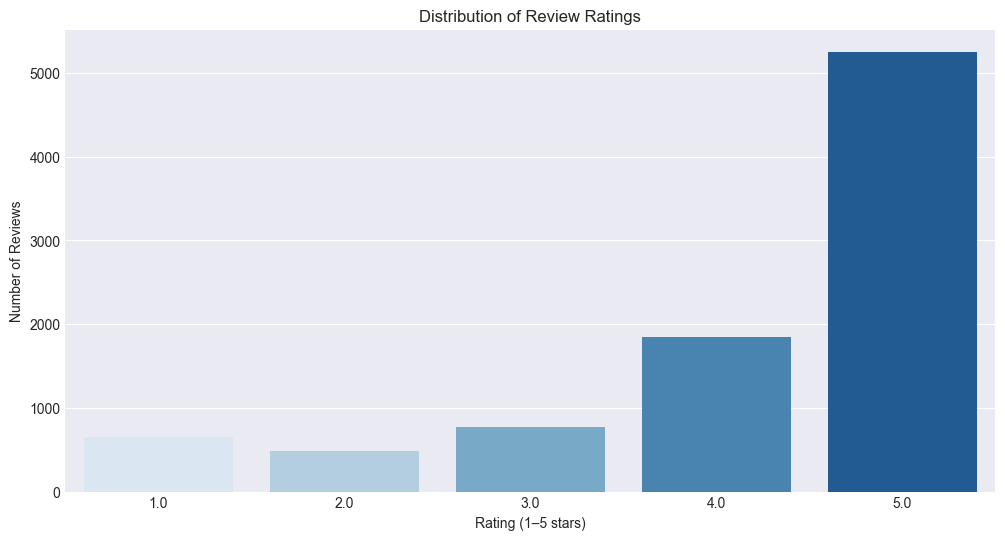

In [22]:

sns.countplot(x="review/score", data=df, palette="Blues")
plt.title("Distribution of Review Ratings")
plt.xlabel("Rating (1–5 stars)")
plt.ylabel("Number of Reviews")
plt.show()

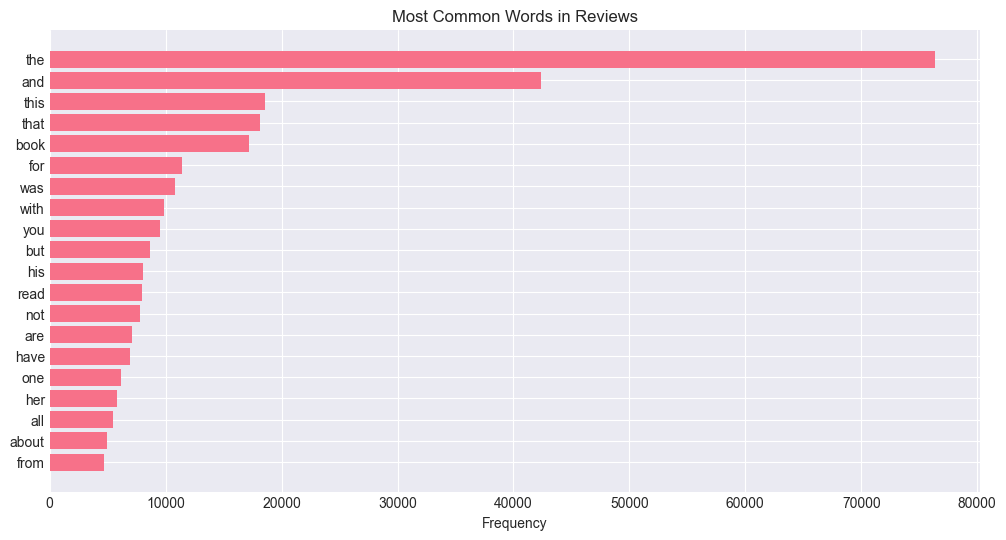

In [19]:

words = " ".join(df['review/text'].dropna()).lower()
words = re.findall(r'\b[a-z]{3,}\b', words)
common = Counter(words).most_common(20)
words, counts = zip(*common)

plt.barh(words[::-1], counts[::-1])
plt.title("Most Common Words in Reviews")
plt.xlabel("Frequency")
plt.show()

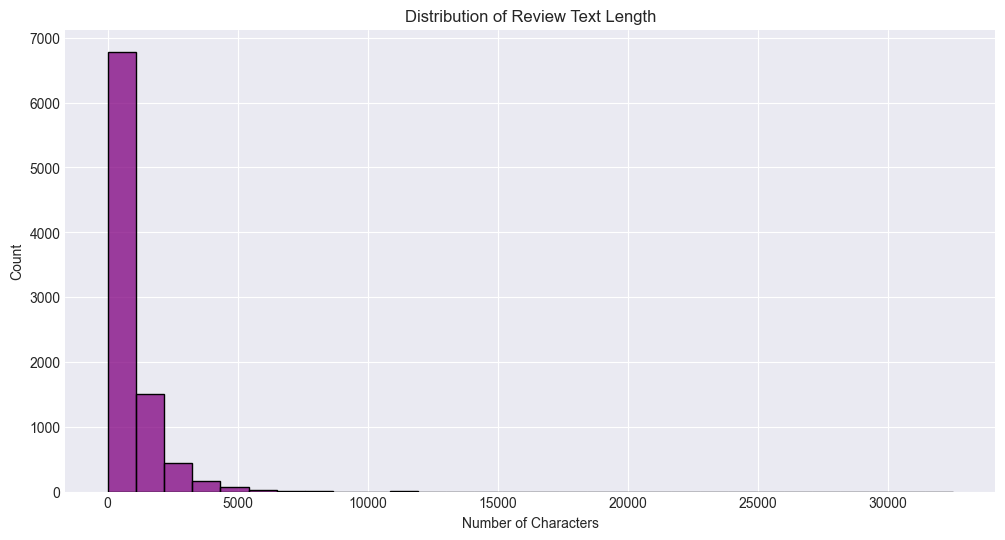

In [23]:
sns.histplot(df['review_text_length'], bins=30, color='purple')
plt.title("Distribution of Review Text Length")
plt.xlabel("Number of Characters")
plt.show()